# Author Discovering - DistilBERT Embeddings and HAN Network on top of it

In [3]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

# Jean
# os.chdir('/content/gdrive/My Drive/NLP_Project_Author_identification')

# Victor
os.chdir('/content/gdrive/MyDrive/6.864 - NLP/NLP_Project_Author_identification')

Mounted at /content/gdrive


In [2]:
%%bash
# Logistics: install the transformers package
pip -q install transformers
pip -q install datasets
pip -q install tqdm
pip -q install sentencepiece

import numpy as np

bash: line 7: import: command not found


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# DistilBERT

## Parsing of the files

In [9]:
# Create index for the author, as well as dictionary to go from index to author

import pandas as pd

test_df = pd.read_csv('data/test_DistilBERT.csv')
idx2author = list(test_df.Author.sort_values().unique()) # we sort values so that it's easy to re-find the order just in case
del test_df
author2idx = {idx2author[i]: i for i in range(len(idx2author))}
n_authors = len(idx2author)
print(f"We have {n_authors} authors.")

We have 50 authors.


In [10]:
### We increase the train size with 25 examples from each author from the text.

import glob
import json

create_set = False

if create_set:
  train_df = pd.DataFrame(columns = ["Author", "Article"], dtype = str)
  for i, filename in enumerate(glob.iglob("/content/gdrive/MyDrive/6.864 - NLP/NLP_Project_Author_identification/C50/C50train/*/*.txt")):
    if i % 100 == 0:
      print(i)
    author = filename.split("/")[8]
    with open(filename) as file:
      text = file.readlines()
    text = [text[i][:-1] for i in range(len(text))]
    if i == 1:
      text11 = text
      print(text)
    train_df.loc[i] = [author, text]

  test_df = pd.DataFrame(columns = ["Author", "Article"], dtype = str)
  for i, filename in enumerate(glob.iglob("/content/gdrive/MyDrive/6.864 - NLP/NLP_Project_Author_identification/C50/C50test/*/*.txt")):
    if i % 100 == 0:
      print(i)
    author = filename.split("/")[8]
    with open(filename) as file:
      text = file.readlines()
    text = [text[i][:-1] for i in range(len(text))]
    if i == 1:
      text11 = text
      print(text)
    test_df.loc[i] = [author, text]

  # Next, we re-attribute some examples from the test to the train to get a 75%/25% split

  authors = test_df.Author.unique()
  test_df_final = pd.DataFrame(columns = ["Author", "Article"], dtype = str)

  for a in authors:
    sub_df = test_df[test_df['Author'] == a]
    mask = np.full(50, False)
    mask[:25] = True
    np.random.seed(34)
    np.random.shuffle(mask)
    train_df = pd.concat([train_df, sub_df.iloc[mask]])
    test_df_final = pd.concat([test_df_final, sub_df.iloc[~mask]])
  
  # Now that we have created train and test, let's move that to JSON files - not the prettiest way at all but it works here

  def proc_row(row, truncation = True, max_sent_length = 128, max_doc_length = 64):
    article = getattr(row, 'Article')
    author = getattr(row, 'Author')
    author_id = author2idx[author]

    samp = {
        "Author": author,
        "Article": article,
        "Author_id": author_id
    }

    return samp

  def preproc_raw():
    train_raw_sentenced = list()
    for index, row in train_df.iterrows():
      train_raw_sentenced.append(proc_row(row))
    json.dump(train_raw_sentenced, open("/content/gdrive/MyDrive/6.864 - NLP/NLP_Project_Author_identification/data/C50_train_raw_sentenced.json", 'w'))

    test_raw_sentenced = list()
    for index, row in test_df_final.iterrows():
      test_raw_sentenced.append(proc_line(row))
    json.dump(test_raw_sentenced, open("/content/gdrive/MyDrive/6.864 - NLP/NLP_Project_Author_identification/data/C50_test_raw_sentenced.json", 'w'))
    
    return train_raw_sentenced, test_raw_sentenced
  
  train_raw_sentenced, test_raw_sentenced = preproc_raw()

else:
  train_raw_sentenced = json.load(open("/content/gdrive/MyDrive/6.864 - NLP/NLP_Project_Author_identification/data/C50_train_raw_sentenced.json", 'r'))
  test_raw_sentenced = json.load(open("/content/gdrive/MyDrive/6.864 - NLP/NLP_Project_Author_identification/data/C50_test_raw_sentenced.json", 'r'))

print(f"Train has {len(train_raw_sentenced)} samples.")
print(f"Test has {len(test_raw_sentenced)} samples.")

Train has 3750 samples.
Test has 1250 samples.


In [11]:
# Average number of sentence per article:
num_sentences = [len(train_raw_sentenced[i]["Article"]) for i in range(len(train_raw_sentenced))]
num_words = []
for art in train_raw_sentenced:
  for sentence in art["Article"]:
    num_words.append(len(sentence.split()))

import numpy as np
print(f"Number of sentences\nThere are on average {np.mean(num_sentences)} sentences per document.\nThe 0.5, 0.75 and 0.9 quantiles are {np.quantile(num_sentences, [0.5, 0.75, 0.9])}")
print(f"Number of sentences\nThere are on average {np.mean(num_words)} sentences per document.\nThe 0.5, 0.75 and 0.9 quantiles are {np.quantile(num_words, [0.5, 0.75, 0.9])}")

Number of sentences
There are on average 17.532533333333333 sentences per document.
The 0.5, 0.75 and 0.9 quantiles are [17. 20. 23.]
Number of sentences
There are on average 28.7667726284089 sentences per document.
The 0.5, 0.75 and 0.9 quantiles are [29. 36. 42.]


In [12]:
train_raw_sentenced[0]

{'Article': ["British life assurance group Scottish Amicable on Thursday announced plans to shed its 170-year old mutual status in preparation for a 1.0 billion pounds ($1.68 billion) flotation on the London stock market in three to five years' time.",
  'The group, based in Stirling, Scotland, said it is to use capital raised by the two-stage proposals to take advantage of opportunities for growth and increase its share of the life and pensions market.',
  'Policyholders are to receive an initial special bonus totalling 75 million pounds after demutualising on May 1 this year, based on the length of time policies have been held.',
  'At the top end of the scale, an individual with a 25-year policy maturing this April will receive 1,503 pounds.',
  'On flotation another, larger payout - expected to amount to at least 200 million pounds but possibly "substantially higher" - will be made.',
  'The move to seek a flotation is the second by a British life group, following plans announced l

## Transformers and tokenizer

In [13]:
### For now we just truncate the context to only take the 512 first tokens - otherwise too long with the positional embedding

import transformers

from transformers import DistilBertModel, DistilBertConfig

example = True

# That could have been a way to increase max_position_embeddings, but I can't figure out how
# configuration = DistilBertConfig(max_position_embeddings=1024)

# Use a pretrained tokenizer with CLASS.from_pretrained() function
# "cased" or "uncased" is whether or not English and english are the same
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-cased') # config=configuration


if example:
  context = train_raw_sentenced[0]["Article"]

  print(context)

  context_ids = tokenizer.batch_encode_plus(context, truncation=True, max_length=512, padding = 'longest',
                                            return_attention_mask = True,
                                            return_tensors = 'pt')
  print(context_ids)
  print(context_ids["input_ids"][0])
  print(tokenizer.convert_ids_to_tokens(context_ids["input_ids"][0]))

  print(len(context_ids["input_ids"][0]))

  print(len([token for token in context_ids["input_ids"][0] if token != 0]))


["British life assurance group Scottish Amicable on Thursday announced plans to shed its 170-year old mutual status in preparation for a 1.0 billion pounds ($1.68 billion) flotation on the London stock market in three to five years' time.", 'The group, based in Stirling, Scotland, said it is to use capital raised by the two-stage proposals to take advantage of opportunities for growth and increase its share of the life and pensions market.', 'Policyholders are to receive an initial special bonus totalling 75 million pounds after demutualising on May 1 this year, based on the length of time policies have been held.', 'At the top end of the scale, an individual with a 25-year policy maturing this April will receive 1,503 pounds.', 'On flotation another, larger payout - expected to amount to at least 200 million pounds but possibly "substantially higher" - will be made.', 'The move to seek a flotation is the second by a British life group, following plans announced last year by Norwich U

Now, let's process everything with the encoder.

## Models

We define two models:
* `AuthorDiscoveringModel2` implements 2 hierarchical of attention
* `AuthorDiscoveringModel3` adds a bidirectional GRU on the sentence embedding, before the sentence attention.

In [14]:
import torch.nn as nn

class ModelOutputs:
    def __init__(self, author_logits=None, loss=None, word_attention = None, sentence_attention = None):
        self.author_logits = author_logits
        self.loss = loss
        self.word_attention = word_attention
        self.sentence_attention = sentence_attention

class WordAttention(nn.Module):
  """
  This is the Word level attention module, aka the low level module.
  """

  def __init__(self, language_model = None ,dropout=0.2, att_dim = None):

    super(WordAttention, self).__init__()
    self.language_model = language_model
    self.dropout = nn.Dropout(dropout)

    if att_dim == None:
      self.attention = nn.Linear(language_model.config.dim, language_model.config.dim)
      self.context_vector = nn.Linear(language_model.config.dim, 1, bias=False)

    else:
      self.attention = nn.Linear(language_model.config.dim, att_dim)
      self.context_vector = nn.Linear(att_dim, 1, bias=False)

    self.tanh = nn.Tanh()
    self.softmax = nn.Softmax(dim = 1)

  def freeze_embeddings(self, freeze=False):
    """
    Set whether to freeze DistilBERT embeddings.
    :param freeze: True to freeze weights
    """
    for layer in self.language_model.parameters():
      layer.trainable = not freeze
  
  def forward(self, input_ids = None, attention_mask = None, author = None):
    '''
    input_ids:          ids of the concatenated input tokens
    attention_mask:     concatenated attention masks
    author:             label (idx) of the author of the articles
    '''
    
    lm_output = self.language_model(
        input_ids = input_ids,
        attention_mask = attention_mask
    )

    last_hidden_state = lm_output.last_hidden_state # size (batch_size * doc_length, seq_len, hidden_size)
    last_hidden_state = self.dropout(last_hidden_state) # size (batch_size * doc_length, seq_len, hidden_size)

    att = self.tanh(self.attention(last_hidden_state)) # size (batch_size * doc_length, seq_len, att_dim)
    att = self.context_vector(att).squeeze(2) # size (batch_size * doc_length, seq_len)
    att = self.softmax(att) # size (batch_size * doc_length, seq_len)

    hidden_state = torch.bmm(last_hidden_state.permute(0,2,1), att.unsqueeze(2)) # size (batch_size * doc_length, hidden_size, 1)
    hidden_state = hidden_state.squeeze(2)

    return hidden_state, att

In [15]:
class AuthorDiscoveringModel2(nn.Module):
  """
  This is the full module that incorporates the word level module defined above.
  """

  def __init__(self, language_model = None ,dropout=0.2, att_dim = None):

    super(AuthorDiscoveringModel2, self).__init__()

    self.hidden_size = language_model.config.dim
    self.dropout = nn.Dropout(dropout)

    self.word_attention = WordAttention(language_model = language_model ,dropout=dropout, att_dim = att_dim) # Word-level attention module
    self.author_outputs = nn.Linear(self.hidden_size, n_authors) # Last layer to perform the classification
    
    if att_dim == None:
      self.attention = nn.Linear(self.hidden_size, self.hidden_size)
      self.context_vector = nn.Linear(self.hidden_size, 1, bias=False)
    else:
      self.attention = nn.Linear(self.hidden_size, att_dim)
      self.context_vector = nn.Linear(att_dim, 1, bias=False)

    self.tanh = nn.Tanh()
    self.softmax = nn.Softmax(dim = 1)


  def forward(self, input_ids=None, attention_mask=None, art_lengths = None, author = None):
    """
    input_ids, attention_mask: {batch * art_max_length, sent_max_length, hidden_size}
    """

    sents, word_att_weights = self.word_attention(input_ids, attention_mask, author) # {batch * art_max_length, hidden_size}

    ### Need to reshape from {batch * art_max_length, hidden_size} --> {batch, art_max_length, hidden_size}

    sents = sents.view(-1, art_max_length, self.hidden_size)

    sents = self.dropout(sents) # size {batch, art_max_length, hidden_size}

    att = self.tanh(self.attention(sents)) # size {batch, art_max_length, att_dim}
    att = self.context_vector(att).squeeze(2) # size {batch, art_max_length}
    att = self.softmax(att) # size {batch, art_max_length}

    hidden_state = torch.bmm(sents.permute(0,2,1), att.unsqueeze(2)) # size (batch_size, hidden_size)

    author_logits = None

    author_logits = self.author_outputs(hidden_state.squeeze(2))  # (batch_size, n_authors)

    total_loss = None

    if author is not None:

        loss_fct = nn.CrossEntropyLoss()
        
        total_loss = loss_fct(author_logits, author)
    
    return ModelOutputs(
        author_logits = author_logits,
        loss = total_loss,
        word_attention = word_att_weights, # Don't really know the size yet
        sentence_attention = att
        )

In [16]:
class AuthorDiscoveringModel3(nn.Module):
  """
  This is the full module that incorporates the word level module defined above.
  """

  def __init__(self, language_model = None ,dropout=0.2, att_dim = None, num_layers = 1, bidirectional = True):

    super(AuthorDiscoveringModel3, self).__init__()

    self.hidden_size = language_model.config.dim
    self.bidirectional = bidirectional
    self.num_layers = num_layers
    self.dropout = nn.Dropout(dropout)

    self.word_attention = WordAttention(language_model = language_model ,dropout=dropout, att_dim = att_dim) # Word-level attention module

    self.gru = nn.GRU(self.hidden_size, self.hidden_size,
                      num_layers = num_layers, batch_first = True, bidirectional = bidirectional, dropout = dropout)

    self.author_outputs = nn.Linear(self.hidden_size, n_authors) # Last layer to perform the classification
    
    if att_dim == None:
      att_dim = self.hidden_size

    self.attention = nn.Linear((1 + self.bidirectional) * self.hidden_size, att_dim)
    self.context_vector = nn.Linear(att_dim, 1, bias=False)

    self.tanh = nn.Tanh()
    self.softmax = nn.Softmax(dim = 1)


  def forward(self, input_ids=None, attention_mask=None, art_lengths = None, author = None):
    """
    input_ids, attention_mask: {batch * art_max_length, sent_max_length, hidden_size}
    """

    sents, word_att_weights = self.word_attention(input_ids, attention_mask, author) # {batch * art_max_length, hidden_size}

    # Reshape from {batch * art_max_length, hidden_size} --> {batch, art_max_length, hidden_size}
    sents = sents.view(-1, art_max_length, self.hidden_size)

    sents_packed = pack_padded_sequence(sents, art_lengths.to("cpu"), batch_first = True, enforce_sorted = False)

    sents_packed, _ = self.gru(sents_packed)

    sents, _ = pad_packed_sequence(sents_packed, batch_first=True)

    sents = self.dropout(sents) # size {batch, art_max_length, hidden_size}

    sents = self.attention(sents)

    att = self.tanh(sents) # size {batch, art_max_length, att_dim}
    att = self.context_vector(att).squeeze(2) # size {batch, art_max_length}
    att = self.softmax(att) # size {batch, art_max_length}

    hidden_state = torch.bmm(sents.permute(0,2,1), att.unsqueeze(2)) # size (batch_size, hidden_size)

    author_logits = None

    author_logits = self.author_outputs(hidden_state.squeeze(2))  # (batch_size, n_authors)

    total_loss = None

    if author is not None:

        loss_fct = nn.CrossEntropyLoss()
        
        total_loss = loss_fct(author_logits, author)
    
    return ModelOutputs(
        author_logits = author_logits,
        loss = total_loss,
        word_attention = word_att_weights, # Don't really know the size yet
        sentence_attention = att
        )

## Training the model

In [17]:
# Initialize the model and use GPU - can be changed from model 2 to model 3 here
lm_pretrained = transformers.AutoModel.from_pretrained('distilbert-base-cased')
model_name = "model3_3layers"

if model_name == "model2":
  model = AuthorDiscoveringModel2(lm_pretrained)
elif model_name == "model3":
  model = AuthorDiscoveringModel3(lm_pretrained)
elif model_name == "model3_3layers":
  model = AuthorDiscoveringModel3(lm_pretrained, num_layers = 3)
else:
  print("Please enter valid model name")
model = model.cuda()

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Then we define the training hyper-parameters, the optimizer, and the learning rate scheduler. Read this [document](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup) to understand how the linear learning rate scheduling influences the learning process.**

In [18]:
## TODO WITH MY PARAMETERS

import torch
import random

# Hyper-parameters: you could try playing with different settings
num_epochs = 15 # Default will be 10 epochs
learning_rate = 3e-5
weight_decay = 1e-5
eps = 1e-6
batch_size = 16 # Default is 16, but maybe that's too small.
warmup_rate = 0.05
art_max_length = 16 # Default is 16. There are on average 17.532533333333333 sentences per document. The 0.5, 0.75 and 0.9 quantiles are [17. 20. 23.]
sent_max_length = 64 # Default is 64. 90% quantile for this in train is 42. We could even try 32 here and double batch_size

# Calculating the number of warmup steps
num_training_cases = len(train_raw_sentenced)
t_total = (num_training_cases // batch_size + 1) * num_epochs
ext_warmup_steps = int(warmup_rate * t_total)

# Initializing an AdamW optimizer
ext_optim = torch.optim.AdamW(model.parameters(), lr=learning_rate,
                              eps=eps, weight_decay=weight_decay)

# Initializing the learning rate scheduler [details are in the BERT paper]
ext_sche = transformers.get_linear_schedule_with_warmup(
    ext_optim, num_warmup_steps=ext_warmup_steps, num_training_steps=t_total
)

print("***** Training Info *****")
print("  Num examples = %d" % t_total)
print("  Num Epochs = %d" % num_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % t_total)

***** Training Info *****
  Num examples = 3525
  Num Epochs = 15
  Batch size = 16
  Total optimization steps = 3525


In [19]:
def gather_batch(batch):
  # Need to pad with empty sentences or truncate, to have up to art_max_length sentences per document

  sent_batch = []
  art_lengths = [len(x["Article"]) for x in batch] # num_sentence size: (batch_size)
  for i, num in enumerate(art_lengths):
    if num > art_max_length:
      sent_batch = sent_batch + (batch[i]["Article"][:art_max_length]) # We truncate because too long
    else:
      sent_batch = sent_batch + (batch[i]["Article"] + (art_max_length - num) * [""]) # We add empty sentences
  
  art_lengths = [l if l <= 16 else 16 for l in art_lengths]

  author_batch = [x['Author'] for x in batch]
  author_id_batch = [x['Author_id'] for x in batch]

  return sent_batch, author_batch, author_id_batch, art_lengths

In [20]:
def vectorize_batch(batch, tokenizer):
    sent_batch, author_batch, author_id_batch, art_lengths = gather_batch(batch) # Sent batch is a list of size (batch_size * art_max_length)

    # Encode the article
    art_encode = tokenizer.batch_encode_plus(
        sent_batch,
        max_length = sent_max_length,
        truncation = True,
        padding = 'longest',
        return_attention_mask = True,
        return_tensors = 'pt'
    )

    sent_lengths = np.array([len([token for token in sentence if token != 0]) for sentence in art_encode['input_ids']]) # size (batch_size * art_max_length)
    sent_lengths = sent_lengths.reshape(len(batch), art_max_length)

    # Move the training batch to GPU
    sent_ids = art_encode['input_ids'].cuda()
    sent_attn_mask = art_encode['attention_mask'].cuda()
    art_lengths = torch.FloatTensor(art_lengths).cuda()
    sent_lengths = torch.FloatTensor(sent_lengths).cuda()

    # Move author to the GPU
    author_id_batch = torch.LongTensor(author_id_batch).cuda()

    return sent_ids, sent_attn_mask, author_id_batch, art_lengths, sent_lengths

In [21]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

Train = False
epoch_to_load = 14

if Train:
  model.train()
  max_grad_norm = 1

  step_id = 0
  for epoch in range(num_epochs):

      random.shuffle(train_raw_sentenced)

      for i in range(0, num_training_cases, batch_size):

          batch = train_raw_sentenced[i: i + batch_size]
          sent_ids, sent_attn_mask, author_id_batch, art_lengths, sent_lengths = vectorize_batch(batch, tokenizer)

          model.zero_grad() # Does the same as ext_optim.zero_grad()
          
          # Get the model outputs, including logits and losses
          # stored as a ModelOutput object
          outputs = model(
              input_ids = sent_ids, 
              attention_mask = sent_attn_mask, 
              art_lengths = art_lengths,
              author = author_id_batch
          )

          # Back-propagate the loss signal and clip the gradients
          loss = outputs.loss.mean()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

          # Update neural network parameters and the learning rate
          ext_optim.step()
          ext_sche.step() # Update learning rate for better convergence


          if step_id % 100 == 0:
              print(f'At step {step_id}, the extraction loss = {loss}')
          
          step_id += 1

      torch.save(model.state_dict(), f"/content/gdrive/MyDrive/6.864 - NLP/NLP_Project_Author_identification/models/author_ID_{model_name}_{epoch}epo.pt") # _3layers

  print('Finished Training')

else:
  model.load_state_dict(torch.load(f"/content/gdrive/MyDrive/6.864 - NLP/NLP_Project_Author_identification/models/author_ID_{model_name}_{epoch_to_load}epo.pt")) # _3layers

## Testing the model

We'll simply maximize the logits out of the model.

In [22]:
def logits_to_author(author_logits):
  '''
  Input sizes:
      author_logits.size() = (batch_size, n_author)
  Output sizes:
      author_pred.size() = (batch_size,)
  '''

  author_id = torch.argmax(author_logits, axis=1, keepdims=True)

  return author_id

def accuracy_metric(author_pred_list, author_gt_list):
  return sum([author_pred_list[i] == author_gt_list[i] for i in range(len(author_pred_list))])/len(author_gt_list)

In [23]:
model.eval()

def eval_model(article_proc_to_use):
  # Prepare the testing set for evaluation
  num_test_cases = len(article_proc_to_use)

  eval_batch_size = 64

  # `author_pred_list` stores the predicted authors
  # in the same order as the contexts of the dev set
  author_pred_list = []
  author_gt_list = [x['Author'] for x in article_proc_to_use]
  article_text = [" ".join(x['Article']) for x in article_proc_to_use]
  # Might need to join the article if I split by sentence first here.

      # art_batch  = [x['Article'] for x in batch]
      # author_batch = [x['Author'] for x in batch]
      # author_id_batch = [x['author_id'] for x in batch]

  for i in range(0, num_test_cases, eval_batch_size):
      eval_batch = article_proc_to_use[i: i + eval_batch_size]
      
      sent_ids, sent_attn_mask, author_id_batch, art_lengths, sent_lengths = vectorize_batch(eval_batch, tokenizer)

      with torch.no_grad():
          outputs = model(
              input_ids = sent_ids,
              attention_mask = sent_attn_mask,
              art_lengths = art_lengths
          )

      author_logits = outputs.author_logits

      author_pred = logits_to_author(author_logits)

      # store predicted answers in lists
      author_pred_list = author_pred_list + author_pred.squeeze().tolist()

  # Translate indexes to author names
  author_pred_list = [idx2author[author_pred_list[i]] for i in range(len(author_pred_list))]


  return author_pred_list, author_gt_list, accuracy_metric(author_pred_list, author_gt_list), article_text

# Print the evaluation results

from sklearn.metrics import f1_score

a_pred_train, a_gt_train, accuracy_train, article_text_train = eval_model(train_raw_sentenced)
a_pred_test, a_gt_test, accuracy_test, article_text_test = eval_model(test_raw_sentenced)

print(f"Training accuracy is {accuracy_train}.")
print(f"Training F1 score is {f1_score(a_gt_train, a_pred_train, average='macro')}.") # Look at the average we should take for the f1 score.
print(f"Testing accuracy is {accuracy_test}.")
print(f"Training F1 score is {f1_score(a_gt_test, a_pred_test, average='macro')}.")

Training accuracy is 1.0.
Training F1 score is 1.0.
Testing accuracy is 0.7568.
Training F1 score is 0.754859798839398.


In [24]:
model_output = pd.DataFrame({"author_pred": a_pred_train + a_pred_test,
                             "author_gt": a_gt_train + a_gt_test,
                             "train": 5000*[0],
                             "article_text": article_text_train + article_text_test})

model_output["train"].iloc[:len(a_pred_train)] = 1


model_output.to_csv(f"/content/gdrive/MyDrive/6.864 - NLP/NLP_Project_Author_identification/Models_outputs/output_author_ID_{model_name}.csv")

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Fine-tuning model per epoch

In [25]:
### We load all the epoch models one after the other, we compute the accuracy and we append it to the dataset

model_accuracy = pd.DataFrame({"model": []
                              ,"epoch": [] 
                              ,"train_accuracy": []
                              ,"test_accuracy": []
                               })

# We need to change the model at 2 points: model_name and in the definition of the model
model_name = "model3_3layers"

if model_name == "model2":
  model = AuthorDiscoveringModel2(lm_pretrained)
elif model_name == "model3":
  model = AuthorDiscoveringModel3(lm_pretrained)
elif model_name == "model3_3layers":
  model = AuthorDiscoveringModel3(lm_pretrained, num_layers = 3)
else:
  print("Please enter valid model name")
model = model.cuda()

for epoch_to_load in range(15):
  # Load the corresponding model
  model.load_state_dict(torch.load(f"/content/gdrive/MyDrive/6.864 - NLP/NLP_Project_Author_identification/models/author_ID_{model_name}_{epoch_to_load}epo.pt"))

  model.eval()

  a_pred_train, a_gt_train, train_accuracy, _ = eval_model(train_raw_sentenced)
  a_pred_test, a_gt_test, test_accuracy, _ = eval_model(test_raw_sentenced)

  model_accuracy = model_accuracy.append({'model': model_name, "epoch": epoch_to_load, "train_accuracy": train_accuracy, "test_accuracy": test_accuracy}, ignore_index=True)

  if epoch_to_load % 3 == 0:
    print(epoch_to_load)

model_accuracy.to_csv(f"/content/gdrive/MyDrive/6.864 - NLP/NLP_Project_Author_identification/Results/{model_name}_model_accuracy.csv")

0
3
6
9
12


Text(0, 0.5, 'Test Accuracy')

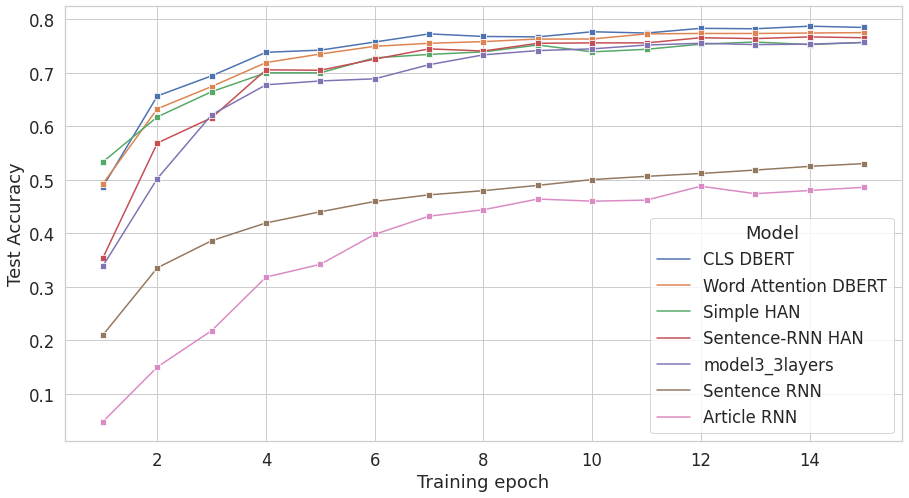

In [6]:
import pandas as pd

model_accuracy = pd.DataFrame({"model": []
                              ,"epoch": [] 
                              ,"train_accuracy": []
                              ,"test_accuracy": []
                               })

for model_num in range(4):
  df_tmp = pd.read_csv(f"/content/gdrive/MyDrive/6.864 - NLP/NLP_Project_Author_identification/Results/model{model_num}_model_accuracy.csv")
  model_accuracy = model_accuracy.append(df_tmp, ignore_index=True)

model_accuracy = model_accuracy.append(pd.read_csv(f"/content/gdrive/MyDrive/6.864 - NLP/NLP_Project_Author_identification/Results/model3_3layers_model_accuracy.csv"),
                                       ignore_index=True)

model_accuracy["epoch"] = model_accuracy["epoch"] + 1

model_accuracy = model_accuracy.append(pd.read_csv(f"/content/gdrive/MyDrive/6.864 - NLP/NLP_Project_Author_identification/Results/Article_Sentence_GRU_model_accuracy.csv"),
                                       ignore_index=True)

### Plot figures

import seaborn as sns
import matplotlib.pyplot as plt

model_accuracy = model_accuracy.replace({"model0": "CLS DBERT",
                        "model1": "Word Attention DBERT", 
                        "model2": "Simple HAN",
                        "model3": "Sentence-RNN HAN",
                        "article": "Article RNN",
                        "sentence": "Sentence RNN"})

model_accuracy = model_accuracy.rename({"model": "Model"}, axis = 1)

# Style
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

# Plot
fig, ax = plt.subplots(figsize=(15,8))

g1 = sns.lineplot(x = "epoch", y="test_accuracy", hue = "Model", data=model_accuracy, marker = "s")
ax.set_facecolor("none")
plt.xlabel("Training epoch")
plt.ylabel("Test Accuracy")

# Legend
# plt.title("Probability to answer the phone given the individual is dialed", fontsize = 18)
# ax.text(x=0, y=-0.2, s='Predicted probability deciles based on LGBM model. \nDecile 0 means individuals in the top 10% of propensity to click',
#         fontsize=12, transform=ax.transAxes)